In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.preprocessing import text,sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D,GlobalMaxPooling1D,MaxPooling1D
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_text as text
import re    #for regex
import string
import re    #for regex
import nltk
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train = pd.read_csv('IMDB Dataset.csv')

In [3]:
train

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


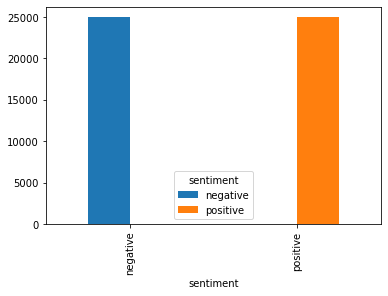

In [4]:
C = ['sentiment']

for i in C:
    ch = pd.crosstab(train[i], train['sentiment'])  
    ch.plot.bar()   
    plt.show() 

In [5]:
labeling = {
    'positive':1, 
    'negative':0
}

train['sentiment'] = train['sentiment'].apply(lambda x : labeling[x])

In [6]:
train.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
9,If you like original gut wrenching laughter yo...,1


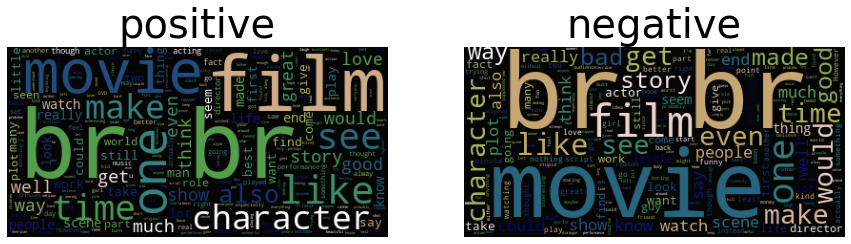

In [7]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
stopword = set(stopwords.words("english"))
subset=train[train.sentiment == 1]
text=subset.review.values
wc= WordCloud(background_color="black",max_words=500,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("positive", fontsize=40)
plt.imshow(wc.recolor(colormap= 'gist_earth'), alpha=0.98)


plt.subplot(122)
subset=train[train.sentiment == 0]
text=subset.review.values
wc= WordCloud(background_color="black",max_words=500,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("negative", fontsize=40)
plt.imshow(wc.recolor(colormap= 'gist_earth'), alpha=0.98)

In [8]:
x_train=train["review"]
y_train=train["sentiment"]

In [9]:
train_x, test_x, train_y, test_y = train_test_split(x_train,y_train, test_size=0.2, random_state=1,shuffle=True)

In [10]:
X_train, X_val, y_train, y_val  = train_test_split(x_train, y_train, test_size=0.16, random_state=1) 

In [11]:
print('Number of reviews in the training set : {}'.format(len(X_train)))
print('Number of reviews in the validation set : {}'.format(len(X_val)))
print('Number of reviews in the testing set : {}'.format(len(test_x)))

Number of reviews in the training set : 42000
Number of reviews in the validation set : 8000
Number of reviews in the testing set : 10000


In [12]:
bert_model_name = 'small_bert/bert_en_uncased_L-8_H-512_A-8'  

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/2'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [13]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/2",
    trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]     
sequence_output = outputs["sequence_output"]

In [14]:
model = tf.keras.Sequential()
model.add(tf.keras.Model(text_input, pooled_output))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='classifier'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 512)               41373185  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
classifier (Dense)           (None, 1)                 513       
Total params: 41,373,698
Trainable params: 41,373,697
Non-trainable params: 1
_________________________________________________________________


In [15]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [16]:
from official.nlp import optimization 
epochs = 5
steps_per_epoch = 625 #tf.data.experimental.cardinality(train_data).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [17]:
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [18]:
history = model.fit(train_x,train_y,
                               validation_data=(X_val, y_val),
                               epochs=epochs)

Epoch 1/5


C:\Users\Daniel\anaconda3\envs\tensorflow_gpu\lib\site-packages\keras\backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


1250/1250 [==============================] - 336s 260ms/step - loss: 0.4056 - binary_accuracy: 0.8064 - val_loss: 0.3027 - val_binary_accuracy: 0.8694
Epoch 2/5
1250/1250 [==============================] - 319s 255ms/step - loss: 0.2587 - binary_accuracy: 0.8936 - val_loss: 0.2900 - val_binary_accuracy: 0.8791
Epoch 3/5
1250/1250 [==============================] - 320s 256ms/step - loss: 0.1810 - binary_accuracy: 0.9303 - val_loss: 0.3205 - val_binary_accuracy: 0.8813
Epoch 4/5
1250/1250 [==============================] - 320s 256ms/step - loss: 0.1717 - binary_accuracy: 0.9349 - val_loss: 0.3205 - val_binary_accuracy: 0.8813
Epoch 5/5
1250/1250 [==============================] - 342s 273ms/step - loss: 0.1716 - binary_accuracy: 0.9353 - val_loss: 0.3205 - val_binary_accuracy: 0.8813


In [19]:
loss, accuracy = model.evaluate(test_x, test_y)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

313/313 [==============================] - 59s 188ms/step - loss: 0.3284 - binary_accuracy: 0.8780
Loss: 0.3283523917198181
Accuracy: 0.878000020980835


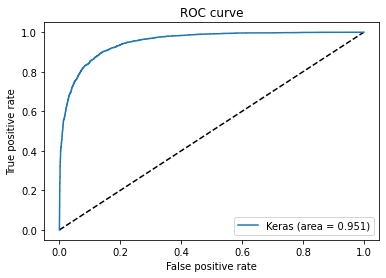

In [23]:
from sklearn.metrics import roc_curve
y_pred_keras =model.predict(test_x).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_y, y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [24]:
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import classification_report
fpr, tpr, thresholds = roc_curve(test_y, y_pred_keras)
RightIndex=(tpr-fpr)
index=np.where(RightIndex==max(RightIndex))#Youden_index

best_threshold=thresholds[index]

print("The best threshold is",best_threshold)
print(classification_report(test_y, y_pred_keras>best_threshold ,digits=4))

The best threshold is [0.4425898]
              precision    recall  f1-score   support

           0     0.8960    0.8610    0.8782      5044
           1     0.8640    0.8983    0.8808      4956

    accuracy                         0.8795     10000
   macro avg     0.8800    0.8797    0.8795     10000
weighted avg     0.8801    0.8795    0.8795     10000



In [185]:
model.save('Test_model_Bert2')

INFO:tensorflow:Assets written to: Test_model_Bert2\assets


INFO:tensorflow:Assets written to: Test_model_Bert2\assets


In [186]:
reloaded_model = tf.saved_model.load('Test_model_Bert2')

In [187]:
examples = ['The movie was good.']  

reloaded_results = reloaded_model(examples)

In [188]:
reloaded_results

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.98480934]], dtype=float32)>

In [157]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()

In [158]:
print('Results from the saved model:')
print_my_examples(examples, reloaded_results)

Results from the saved model:
input: The movie was good             : score: 0.975086



In [159]:
reloaded_results

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.975086]], dtype=float32)>

In [142]:
def print_my_examples2(inputs, results):
  result_for_printing = \
    [f'{results[i][0]:.6f}'
          for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()

In [143]:
print_my_examples2(examples, reloaded_results)

0.975086



In [ ]:
####  L-8_H-128 BERT ####

In [25]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/2",
    trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]     
sequence_output = outputs["sequence_output"]

In [26]:
modelv2 = tf.keras.Sequential()
modelv2.add(tf.keras.Model(text_input, pooled_output))
modelv2.add(tf.keras.layers.Dropout(0.1))
modelv2.add(tf.keras.layers.Dense(1, activation=None, name='classifier'))


modelv2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 128)               5575553   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
classifier (Dense)           (None, 1)                 129       
Total params: 5,575,682
Trainable params: 5,575,681
Non-trainable params: 1
_________________________________________________________________


In [27]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [28]:
 from official.nlp import optimization 
epochs = 5
steps_per_epoch = 625 #tf.data.experimental.cardinality(train_data).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [29]:
modelv2.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [30]:
history = modelv2.fit(train_x,train_y,
                               validation_data=(X_val, y_val),
                               epochs=epochs)

Epoch 1/5
1250/1250 [==============================] - 304s 234ms/step - loss: 0.5143 - binary_accuracy: 0.7232 - val_loss: 0.3946 - val_binary_accuracy: 0.8259
Epoch 2/5
1250/1250 [==============================] - 296s 237ms/step - loss: 0.3957 - binary_accuracy: 0.8148 - val_loss: 0.3653 - val_binary_accuracy: 0.8332
Epoch 3/5
1250/1250 [==============================] - 305s 244ms/step - loss: 0.3661 - binary_accuracy: 0.8324 - val_loss: 0.3655 - val_binary_accuracy: 0.8378
Epoch 4/5
1250/1250 [==============================] - 304s 243ms/step - loss: 0.3640 - binary_accuracy: 0.8320 - val_loss: 0.3655 - val_binary_accuracy: 0.8378
Epoch 5/5
1250/1250 [==============================] - 303s 242ms/step - loss: 0.3633 - binary_accuracy: 0.8333 - val_loss: 0.3655 - val_binary_accuracy: 0.8378


In [33]:
loss, accuracy = modelv2.evaluate(test_x, test_y)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

313/313 [==============================] - 49s 155ms/step - loss: 0.3697 - binary_accuracy: 0.8334
Loss: 0.3696764409542084
Accuracy: 0.8334000110626221


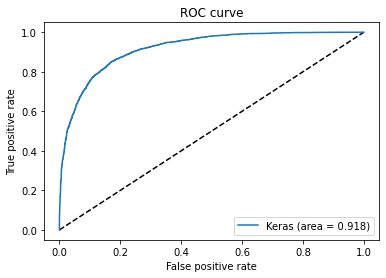

In [34]:
from sklearn.metrics import roc_curve
y_pred_keras =modelv2.predict(test_x).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_y, y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [36]:
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import classification_report
fpr, tpr, thresholds = roc_curve(test_y, y_pred_keras)
RightIndex=(tpr-fpr)
index=np.where(RightIndex==max(RightIndex))#Youden_index

best_threshold=thresholds[index]

print("The best threshold is",best_threshold)
print(classification_report(test_y, y_pred_keras>best_threshold ,digits=4))

The best threshold is [-0.01694425]
              precision    recall  f1-score   support

           0     0.8492    0.8295    0.8392      5044
           1     0.8305    0.8501    0.8402      4956

    accuracy                         0.8397     10000
   macro avg     0.8398    0.8398    0.8397     10000
weighted avg     0.8399    0.8397    0.8397     10000



In [37]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/2",
    trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]     
sequence_output = outputs["sequence_output"]

In [39]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense


model_2 = tf.keras.Sequential()
model_2.add(tf.keras.Model(text_input, sequence_output))
model_2.add(LSTM(128))
model_2.add((Dropout(0.2)))
model_2.add(tf.keras.layers.Dense(1, activation=None, name='classifier'))       

model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         (None, 128, 128)          4782465   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
classifier (Dense)           (None, 1)                 129       
Total params: 4,914,178
Trainable params: 4,914,177
Non-trainable params: 1
_________________________________________________________________


In [40]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [41]:
 from official.nlp import optimization 
epochs = 5
steps_per_epoch = 625 #tf.data.experimental.cardinality(train_data).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [42]:
model_2.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [43]:
history = model_2.fit(train_x,train_y,
                               validation_data=(X_val, y_val),
                               epochs=epochs)

Epoch 1/5
1250/1250 [==============================] - 305s 235ms/step - loss: 0.5407 - binary_accuracy: 0.6938 - val_loss: 0.4313 - val_binary_accuracy: 0.7974
Epoch 2/5
1250/1250 [==============================] - 306s 245ms/step - loss: 0.4326 - binary_accuracy: 0.7901 - val_loss: 0.4125 - val_binary_accuracy: 0.8058
Epoch 3/5
1250/1250 [==============================] - 292s 233ms/step - loss: 0.4101 - binary_accuracy: 0.8044 - val_loss: 0.4088 - val_binary_accuracy: 0.8121
Epoch 4/5
1250/1250 [==============================] - 284s 227ms/step - loss: 0.4076 - binary_accuracy: 0.8058 - val_loss: 0.4088 - val_binary_accuracy: 0.8121
Epoch 5/5
1250/1250 [==============================] - 289s 231ms/step - loss: 0.4070 - binary_accuracy: 0.8062 - val_loss: 0.4088 - val_binary_accuracy: 0.8121


In [44]:
loss, accuracy = model_2.evaluate(test_x, test_y)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

313/313 [==============================] - 55s 175ms/step - loss: 0.4089 - binary_accuracy: 0.8105
Loss: 0.4089291989803314
Accuracy: 0.8105000257492065


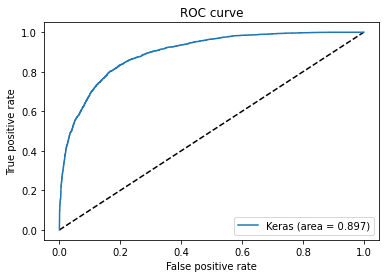

In [45]:
from sklearn.metrics import roc_curve
y_pred_keras =model_2.predict(test_x).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_y, y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [46]:
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import classification_report
fpr, tpr, thresholds = roc_curve(test_y, y_pred_keras)
RightIndex=(tpr-fpr)
index=np.where(RightIndex==max(RightIndex))#Youden_index

best_threshold=thresholds[index]

print("The best threshold is",best_threshold)
print(classification_report(test_y, y_pred_keras>best_threshold ,digits=4))

The best threshold is [0.21646738]
              precision    recall  f1-score   support

           0     0.8105    0.8343    0.8222      5044
           1     0.8261    0.8015    0.8136      4956

    accuracy                         0.8180     10000
   macro avg     0.8183    0.8179    0.8179     10000
weighted avg     0.8182    0.8180    0.8179     10000



In [47]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
model_3 = tf.keras.Sequential()
model_3.add(tf.keras.Model(text_input, sequence_output))
model_3.add(LSTM(128))
model_3.add((Dropout(0.2)))
model_3.add(tf.keras.layers.Dense(1, activation='sigmoid', name='classifier'))       

model_3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Functional)         (None, 128, 128)          4782465   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
classifier (Dense)           (None, 1)                 129       
Total params: 4,914,178
Trainable params: 4,914,177
Non-trainable params: 1
_________________________________________________________________


In [48]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [49]:
 from official.nlp import optimization 
epochs = 5
steps_per_epoch = 625 #tf.data.experimental.cardinality(train_data).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [50]:
model_3.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [51]:
history = model_3.fit(train_x,train_y,
                               validation_data=(X_val, y_val),
                               epochs=epochs)

Epoch 1/5


C:\Users\Daniel\anaconda3\envs\tensorflow_gpu\lib\site-packages\keras\backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


1250/1250 [==============================] - 291s 230ms/step - loss: 0.4467 - binary_accuracy: 0.7857 - val_loss: 0.4109 - val_binary_accuracy: 0.8160
Epoch 2/5
1250/1250 [==============================] - 292s 234ms/step - loss: 0.3781 - binary_accuracy: 0.8338 - val_loss: 0.3869 - val_binary_accuracy: 0.8349
Epoch 3/5
1250/1250 [==============================] - 281s 225ms/step - loss: 0.3574 - binary_accuracy: 0.8427 - val_loss: 0.3879 - val_binary_accuracy: 0.8356
Epoch 4/5
1250/1250 [==============================] - 288s 230ms/step - loss: 0.3556 - binary_accuracy: 0.8435 - val_loss: 0.3879 - val_binary_accuracy: 0.8356
Epoch 5/5
1250/1250 [==============================] - 277s 222ms/step - loss: 0.3532 - binary_accuracy: 0.8467 - val_loss: 0.3879 - val_binary_accuracy: 0.8356


In [52]:
loss, accuracy = model_3.evaluate(test_x, test_y)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

313/313 [==============================] - 55s 174ms/step - loss: 0.3893 - binary_accuracy: 0.8328
Loss: 0.3893263339996338
Accuracy: 0.8327999711036682


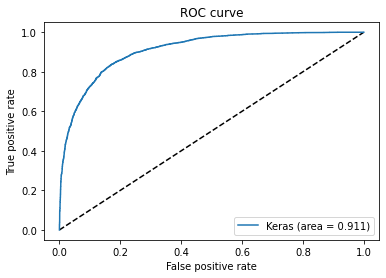

In [61]:
from sklearn.metrics import roc_curve
y_pred_keras =model_3.predict(test_x).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_y, y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [55]:
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import classification_report
fpr, tpr, thresholds = roc_curve(test_y, y_pred_keras)
RightIndex=(tpr-fpr)
index=np.where(RightIndex==max(RightIndex))#Youden_index

best_threshold=thresholds[index]

print("The best threshold is",best_threshold)
print(classification_report(test_y, y_pred_keras>best_threshold ,digits=4))

The best threshold is [0.21646738]
              precision    recall  f1-score   support

           0     0.8105    0.8343    0.8222      5044
           1     0.8261    0.8015    0.8136      4956

    accuracy                         0.8180     10000
   macro avg     0.8183    0.8179    0.8179     10000
weighted avg     0.8182    0.8180    0.8179     10000



In [56]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"    
    
hub_layer = hub.KerasLayer(embedding,output_shape=[128], input_shape=[], dtype=tf.string, trainable=True)

In [57]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
model_4 = tf.keras.Sequential()
model_4.add(hub_layer)
model_4.add(tf.keras.layers.Reshape((1,128)))
model_4.add(LSTM(128))
model_4.add((Dropout(0.2)))
model_4.add(Dense(1,activation='sigmoid',name='classifier'))            

model_4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
reshape (Reshape)            (None, 1, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
classifier (Dense)           (None, 1)                 129       
Total params: 124,774,401
Trainable params: 124,774,401
Non-trainable params: 0
_________________________________________________________________


In [58]:
model_4.compile(loss = "binary_crossentropy",
                 optimizer = 'adam',
                metrics=['accuracy'])

In [59]:
history = model_4.fit(train_x,train_y,
                               validation_data=(X_val, y_val),
                               epochs=10)

Epoch 1/10
1250/1250 [==============================] - 46s 33ms/step - loss: 0.3233 - accuracy: 0.8611 - val_loss: 0.2590 - val_accuracy: 0.8944
Epoch 2/10
1250/1250 [==============================] - 40s 32ms/step - loss: 0.1525 - accuracy: 0.9416 - val_loss: 0.2910 - val_accuracy: 0.8882
Epoch 3/10
1250/1250 [==============================] - 39s 31ms/step - loss: 0.0738 - accuracy: 0.9712 - val_loss: 0.4222 - val_accuracy: 0.8744
Epoch 4/10
1250/1250 [==============================] - 39s 31ms/step - loss: 0.0455 - accuracy: 0.9806 - val_loss: 0.5566 - val_accuracy: 0.8740
Epoch 5/10
1250/1250 [==============================] - 41s 33ms/step - loss: 0.0348 - accuracy: 0.9852 - val_loss: 0.6357 - val_accuracy: 0.8742
Epoch 6/10
1250/1250 [==============================] - 40s 32ms/step - loss: 0.0227 - accuracy: 0.9914 - val_loss: 0.7193 - val_accuracy: 0.8711
Epoch 7/10
1250/1250 [==============================] - 39s 31ms/step - loss: 0.0186 - accuracy: 0.9933 - val_loss: 0.7447 -

In [60]:
loss, accuracy = model_4.evaluate(test_x, test_y)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

313/313 [==============================] - 3s 8ms/step - loss: 0.9421 - accuracy: 0.8705
Loss: 0.9420522451400757
Accuracy: 0.8705000281333923


In [53]:
from keras import backend as K


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [62]:
model_4.compile(loss = "binary_crossentropy",
                 optimizer = 'adam',
                metrics=['acc',f1_m,precision_m, recall_m])

In [63]:
history = model_4.fit(train_x,train_y,
                               validation_data=(X_val, y_val),
                               epochs=10)

Epoch 1/10
1250/1250 [==============================] - 43s 33ms/step - loss: 0.0088 - acc: 0.9970 - f1_m: 0.9969 - precision_m: 0.9971 - recall_m: 0.9970 - val_loss: 0.9934 - val_acc: 0.8643 - val_f1_m: 0.8556 - val_precision_m: 0.8824 - val_recall_m: 0.8374
Epoch 2/10
1250/1250 [==============================] - 41s 33ms/step - loss: 0.0056 - acc: 0.9983 - f1_m: 0.9982 - precision_m: 0.9981 - recall_m: 0.9984 - val_loss: 0.9511 - val_acc: 0.8670 - val_f1_m: 0.8637 - val_precision_m: 0.8573 - val_recall_m: 0.8765
Epoch 3/10
1250/1250 [==============================] - 39s 31ms/step - loss: 0.0026 - acc: 0.9991 - f1_m: 0.9991 - precision_m: 0.9991 - recall_m: 0.9992 - val_loss: 1.0786 - val_acc: 0.8689 - val_f1_m: 0.8642 - val_precision_m: 0.8680 - val_recall_m: 0.8671
Epoch 4/10
1250/1250 [==============================] - 39s 31ms/step - loss: 0.0064 - acc: 0.9976 - f1_m: 0.9975 - precision_m: 0.9977 - recall_m: 0.9976 - val_loss: 0.9829 - val_acc: 0.8655 - val_f1_m: 0.8625 - val_pre

In [64]:
loss, accuracy, f1_score, precision, recall = model_4.evaluate(test_x, test_y, verbose=0)

In [65]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'f1: {f1_score}')
print(f'precision: {precision}')
print(f'recall: {recall}')

Loss: 1.0574673414230347
Accuracy: 0.8629000186920166
f1: 0.8575092554092407
precision: 0.8726307153701782
recall: 0.8501276969909668


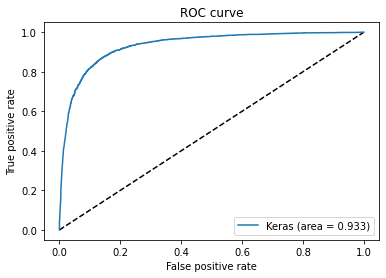

In [66]:
from sklearn.metrics import roc_curve
y_pred_keras =model_4.predict(test_x).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_y, y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [67]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"    
    
hub_layer = hub.KerasLayer(embedding,output_shape=[128], input_shape=[], dtype=tf.string, trainable=True)

In [68]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
model_42 = tf.keras.Sequential()
model_42.add(hub_layer)
model_42.add(tf.keras.layers.Reshape((1,128)))
model_42.add(Bidirectional(LSTM(128,return_sequences=True,dropout=0.3)))
model_42.add(Dropout(0.3))
model_42.add(Bidirectional(LSTM(128))) #lstm with 100 neurons
model_42.add(Dropout(0.3))
model_42.add(Dense(1,activation='sigmoid'))      

model_42.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_7 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 128)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1, 256)            263168    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                

In [69]:
model_42.compile(loss = "binary_crossentropy",
                 optimizer = 'adam',
                metrics=['acc',f1_m,precision_m, recall_m])

In [70]:
history = model_42.fit(train_x,train_y,
                               validation_data=(X_val, y_val),
                               epochs=10)

Epoch 1/10
1250/1250 [==============================] - 50s 37ms/step - loss: 0.3266 - acc: 0.8566 - f1_m: 0.8554 - precision_m: 0.8568 - recall_m: 0.8667 - val_loss: 0.2574 - val_acc: 0.8926 - val_f1_m: 0.8882 - val_precision_m: 0.8956 - val_recall_m: 0.8871
Epoch 2/10
1250/1250 [==============================] - 47s 37ms/step - loss: 0.1626 - acc: 0.9389 - f1_m: 0.9369 - precision_m: 0.9395 - recall_m: 0.9385 - val_loss: 0.2774 - val_acc: 0.8885 - val_f1_m: 0.8854 - val_precision_m: 0.8850 - val_recall_m: 0.8926
Epoch 3/10
1250/1250 [==============================] - 47s 37ms/step - loss: 0.0868 - acc: 0.9676 - f1_m: 0.9666 - precision_m: 0.9679 - recall_m: 0.9675 - val_loss: 0.3444 - val_acc: 0.8763 - val_f1_m: 0.8708 - val_precision_m: 0.8772 - val_recall_m: 0.8717
Epoch 4/10
1250/1250 [==============================] - 46s 37ms/step - loss: 0.0577 - acc: 0.9765 - f1_m: 0.9756 - precision_m: 0.9782 - recall_m: 0.9748 - val_loss: 0.4740 - val_acc: 0.8750 - val_f1_m: 0.8698 - val_pre

In [71]:
loss, accuracy, f1_score, precision, recall = model_42.evaluate(test_x, test_y, verbose=0)

In [72]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'f1: {f1_score}')
print(f'precision: {precision}')
print(f'recall: {recall}')

Loss: 0.8045042753219604
Accuracy: 0.8690999746322632
f1: 0.8653731346130371
precision: 0.8600131273269653
recall: 0.878085196018219


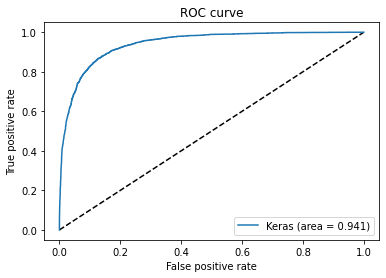

In [73]:
from sklearn.metrics import roc_curve
y_pred_keras =model_42.predict(test_x).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_y, y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [74]:
model_42.save('Test_model_hub')

INFO:tensorflow:Assets written to: Test_model_hub\assets


INFO:tensorflow:Assets written to: Test_model_hub\assets


In [75]:
reloaded_model = tf.saved_model.load('Test_model_hub')

In [76]:
examples = ['Rubbish ']  # this is the same sentence tried earlier]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))

In [77]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()

In [51]:
print('Results from the saved model:')
print_my_examples(examples, reloaded_results)

Results from the saved model:
input: Rubbish                        : score: 0.500001



In [12]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"    
    
hub_layer = hub.KerasLayer(embedding,output_shape=[128], input_shape=[], dtype=tf.string, trainable=True)

In [13]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
model_43 = tf.keras.Sequential()
model_43.add(hub_layer)
model_43.add(tf.keras.layers.Reshape((1,128)))
model_43.add(Bidirectional(LSTM(128)))
model_43.add(Dense(1,activation='sigmoid'))      
model_43.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(3e-3),metrics=['accuracy'])
model_43.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
reshape (Reshape)            (None, 1, 128)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 124,906,113
Trainable params: 124,906,113
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model_43.fit(train_x, train_y, batch_size=128, verbose=1, epochs=20,  validation_split= 0.1)

Epoch 1/20
282/282 [==============================] - 15s 39ms/step - loss: 0.3260 - accuracy: 0.8567 - val_loss: 0.2609 - val_accuracy: 0.8888
Epoch 2/20
282/282 [==============================] - 10s 35ms/step - loss: 0.1324 - accuracy: 0.9491 - val_loss: 0.3401 - val_accuracy: 0.8780
Epoch 3/20
282/282 [==============================] - 10s 35ms/step - loss: 0.0641 - accuracy: 0.9738 - val_loss: 0.4863 - val_accuracy: 0.8745
Epoch 4/20
282/282 [==============================] - 10s 36ms/step - loss: 0.0515 - accuracy: 0.9786 - val_loss: 0.5202 - val_accuracy: 0.8742
Epoch 5/20
282/282 [==============================] - 10s 35ms/step - loss: 0.0300 - accuracy: 0.9893 - val_loss: 0.6563 - val_accuracy: 0.8675
Epoch 6/20
282/282 [==============================] - 10s 35ms/step - loss: 0.0163 - accuracy: 0.9945 - val_loss: 0.7623 - val_accuracy: 0.8727
Epoch 7/20
282/282 [==============================] - 10s 36ms/step - loss: 0.0113 - accuracy: 0.9958 - val_loss: 0.7381 - val_accuracy:

In [15]:
loss, accuracy = model_43.evaluate(test_x, test_y)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

313/313 [==============================] - 2s 6ms/step - loss: 0.8589 - accuracy: 0.8682
Loss: 0.8588919043540955
Accuracy: 0.8682000041007996


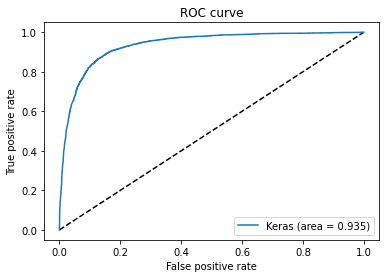

In [16]:
from sklearn.metrics import roc_curve
y_pred_keras = model_43.predict(test_x).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_y, y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [18]:
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import classification_report
fpr, tpr, thresholds = roc_curve(test_y, y_pred_keras)
RightIndex=(tpr-fpr)
index=np.where(RightIndex==max(RightIndex))#Youden_index

best_threshold=thresholds[index]

print("The best threshold is",best_threshold)
print(classification_report(test_y, y_pred_keras>best_threshold ,digits=4))

The best threshold is [0.60338086]
              precision    recall  f1-score   support

           0     0.8895    0.8456    0.8670      5044
           1     0.8503    0.8931    0.8712      4956

    accuracy                         0.8691     10000
   macro avg     0.8699    0.8693    0.8691     10000
weighted avg     0.8701    0.8691    0.8690     10000

